# 평가 조건
일반 영화(synopsis_gen.txt)와 예술 영화(synopsis_art.txt)를 Target으로 선정하고, synopsis.txt를 제외한 나머지 장르를 Attribute로 삼아 WEAT Score를 비교해보도록 하겠습니다.


1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
    - 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.


# 모듈 임포트

In [1]:
import os
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt
from gensim.models import Word2Vec

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; 

np.random.seed(42)

# 데이터 불러오기

In [2]:
txt_path = os.getenv('HOME') + '/aiffel/weat/'

txt_files = []
for file_name in os.listdir(txt_path):
    if file_name.endswith(".txt"):
        txt_files.append(file_name)

# .txt 확장자를 가진 파일들의 목록 출력
print(txt_files)

['synopsis_fantasy.txt', 'synopsis_crime.txt', 'synopsis_western.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 'synopsis_art.txt', 'synopsis_animation.txt', 'synopsis_documentary.txt', 'synopsis_comedy.txt', 'synopsis_mystery.txt', 'synopsis_etc.txt', 'synopsis_action.txt', 'synopsis_adventure.txt', 'synopsis_horror.txt', 'synopsis_war.txt', 'synopsis_SF.txt', 'synopsis_gen.txt', 'synopsis_historical.txt', 'synopsis_family.txt', 'synopsis_drama.txt', 'synopsis_show.txt', 'synopsis.txt', 'synopsis_thriller.txt', 'synopsis_adult.txt']


In [3]:
print('데이터 수:',len(txt_files))

unique_values = set(txt_files)

if len(txt_files) == len(unique_values):
    print("모든 값이 유일합니다.")
else:
    print("중복된 값이 있습니다.")

데이터 수: 24
모든 값이 유일합니다.


- 영화 시놉시스는 총 24개가 있으며, 중복된 데이터는 없습니다.

## 데이터 확인
- 예시로 하나의 데이터만 확인해보도록 하겠습니다.

In [5]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis_fantasy.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

일상적인 사물에 깃든 정령들의 이야기를 다룬 미스테리물. 인터넷 상영을 목적으로 제작된 작품.
 몸과 마음이 하나되어 한눈에 절대 헤어질 수 없는 여인을 만났던 한 남자가 있다. 삶과 죽음을 함께 하리라 생각한 그에게 갑작스레 다가온 것은 그녀의 작별인사. 그렇게 다정했던 그녀가 한순간에 변심해버린 사연을 그는 모른다. 아미의 단 한가지 소원은 지훈과 수현의 화해. 그러나 그 과정에서 아미는 자기도 모르게 지훈을 사랑하게 된다. 하지만 결정적인 순간에 역시 노미의 계략으로 지훈과 수현은 영원히 결별하게 된다. 동시에 노미는 아미에 대한 배신감과 아르고스에게 아미가 사랑하고 있음을 고하고 아미는 오르고스로부터 지훈과의 이별을 통보받는다. 아미는 정령으로서 생을 포기하고 인간이 되어 지훈을 만나겠다는 결심을 한다. 노미는 자신의 사랑을 고백하며 아미를 설득하지만 아미는 이미 죽음을 결심, 결국 사람의 몸으로 지훈을 만나려하는 아미의 계획은 노미에 의해 수포로 돌아가고 아미는 지훈의 꿈 속에 나타나 이별을 고한다.
1943년, 공산당원들을 소탕하려는 작전 하에 크로아티아 군인들이 길을 떠난다.
 하지만 매복한 병사들을 상대하고 초자연현상을 겪으면서 하나 둘씩 목숨을 잃고, 그 중 ‘마틴’만이 살아남는다.
 그리고 시간이 흘러 1993년,
 세르비안인들과의 전쟁 속에서 한 무리의 군인들이 일명 '죽은 자의 땅'으로 이동하고,
 그곳에서 다시 똑같은 기이한 현상이 일어나는데...
2021년, 정신 질환자를 치료하기 위해 사람의 꿈 속으로 들어가 그 꿈을 바꿀 수 있는 약이 개발된다.
 ‘악마’라는 가명을 쓰는 연쇄 살인마는 이 약을 이용해 살인을 저지른다.
 마약 중독자인 로사와 고객 서비스 상담원인 에단은 형편없는 현실에서 상상만 해 왔던 것을 꿈속에서


# 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
- Okt 형태소 분석기를 사용하여 명사만 추출하도록 하겠습니다.
- 또한 명사 중 1글자는 제외시켜주겠습니다.

In [6]:
def read_token(txt_data):
    okt = Okt()
    result = []
    for i in tqdm(txt_data):    
        with open(os.getenv('HOME')+'/aiffel/weat/'+i, 'r') as fread: 
            print(i, '파일을 읽고 있습니다.')
            while True:
                line = fread.readline() 
                if not line: 
                    break 
                tokenlist = okt.pos(line, stem=True, norm=True)
                token = []
                for word in tokenlist:
                    if len(word[0]) > 1 and word[1] in ["Noun"]:
                        token.append((word[0]))
                result.append(token)
                
    return result

In [7]:
filtered_data = [file for file in txt_files if file not in ['synopsis_gen.txt', 'synopsis_art.txt','synopsis.txt']]

all_token = read_token(filtered_data)

  0%|          | 0/21 [00:00<?, ?it/s]

synopsis_fantasy.txt 파일을 읽고 있습니다.


  5%|▍         | 1/21 [00:10<03:23, 10.15s/it]

synopsis_crime.txt 파일을 읽고 있습니다.


 10%|▉         | 2/21 [00:20<03:14, 10.26s/it]

synopsis_western.txt 파일을 읽고 있습니다.


 14%|█▍        | 3/21 [00:20<01:43,  5.76s/it]

synopsis_romance.txt 파일을 읽고 있습니다.


 19%|█▉        | 4/21 [00:59<05:15, 18.54s/it]

synopsis_musical.txt 파일을 읽고 있습니다.


 24%|██▍       | 5/21 [01:00<03:17, 12.32s/it]

synopsis_animation.txt 파일을 읽고 있습니다.


 29%|██▊       | 6/21 [01:49<06:11, 24.80s/it]

synopsis_documentary.txt 파일을 읽고 있습니다.


 33%|███▎      | 7/21 [02:50<08:35, 36.83s/it]

synopsis_comedy.txt 파일을 읽고 있습니다.


 38%|███▊      | 8/21 [03:32<08:16, 38.21s/it]

synopsis_mystery.txt 파일을 읽고 있습니다.


 43%|████▎     | 9/21 [03:38<05:38, 28.17s/it]

synopsis_etc.txt 파일을 읽고 있습니다.


 48%|████▊     | 10/21 [03:58<04:42, 25.72s/it]

synopsis_action.txt 파일을 읽고 있습니다.


 52%|█████▏    | 11/21 [04:41<05:10, 31.08s/it]

synopsis_adventure.txt 파일을 읽고 있습니다.


 57%|█████▋    | 12/21 [04:45<03:25, 22.88s/it]

synopsis_horror.txt 파일을 읽고 있습니다.


 62%|██████▏   | 13/21 [05:09<03:05, 23.13s/it]

synopsis_war.txt 파일을 읽고 있습니다.


 67%|██████▋   | 14/21 [05:12<02:00, 17.16s/it]

synopsis_SF.txt 파일을 읽고 있습니다.


 71%|███████▏  | 15/21 [05:21<01:27, 14.52s/it]

synopsis_historical.txt 파일을 읽고 있습니다.


 76%|███████▌  | 16/21 [05:22<00:52, 10.56s/it]

synopsis_family.txt 파일을 읽고 있습니다.


 81%|████████  | 17/21 [05:25<00:33,  8.39s/it]

synopsis_drama.txt 파일을 읽고 있습니다.


 86%|████████▌ | 18/21 [08:04<02:40, 53.48s/it]

synopsis_show.txt 파일을 읽고 있습니다.


 90%|█████████ | 19/21 [08:08<01:17, 38.54s/it]

synopsis_thriller.txt 파일을 읽고 있습니다.


 95%|█████████▌| 20/21 [08:26<00:32, 32.34s/it]

synopsis_adult.txt 파일을 읽고 있습니다.


100%|██████████| 21/21 [08:46<00:00, 25.08s/it]


In [8]:
all_token[:10]

[['일상', '사물', '정령', '이야기', '미스테리물', '인터넷', '상영', '목적', '제작', '작품'],
 ['마음',
  '하나',
  '한눈',
  '절대',
  '여인',
  '남자',
  '죽음',
  '하리',
  '생각',
  '갑작스레',
  '그녀',
  '작별인사',
  '그녀',
  '한순간',
  '변심',
  '사연',
  '아미',
  '한가지',
  '소원',
  '지훈',
  '수현',
  '화해',
  '과정',
  '아미',
  '자기',
  '지훈',
  '사랑',
  '결정',
  '순간',
  '역시',
  '노미',
  '계략',
  '지훈',
  '수현',
  '결별',
  '동시',
  '노미',
  '아미',
  '대한',
  '배신',
  '아르고스',
  '아미가',
  '사랑',
  '고하',
  '아미',
  '고스',
  '로부터',
  '지훈',
  '이별',
  '통보',
  '아미',
  '정령',
  '포기',
  '인간',
  '지훈',
  '결심',
  '노미',
  '자신',
  '사랑',
  '고백',
  '아미',
  '설득',
  '아미',
  '죽음',
  '결심',
  '사람',
  '지훈',
  '아미',
  '계획',
  '노미',
  '수포',
  '아미',
  '지훈',
  '이별'],
 ['공산', '당원', '소탕', '작전', '크로아티아', '군인'],
 ['매복', '병사', '상대', '초자연현상', '하나', '목숨', '마틴'],
 ['시간'],
 ['세르', '전쟁', '무리', '군인', '일명', '자의', '이동'],
 ['다시', '현상'],
 ['정신', '질환', '치료', '위해', '사람', '개발'],
 ['악마', '가명', '연쇄', '살인마', '이용', '살인'],
 ['마약', '중독', '로사', '고객', '서비스', '상담', '원인', '형편', '현실', '상상', '꿈속']]

- 2글자 이상의 명사가 잘 추출된것을 확인할 수 있습니다.

# 추출된 결과로 embedding model 만들기
Word2Vec 모델을 사용하여 토큰화된 텍스트 데이터를 학습시키는 부분입니다.

사용된 매개변수는 다음과 같습니다.

- tokenized: 텍스트 데이터를 토큰화한 결과물을 입력으로 사용합니다. 이는 단어들이 토큰 리스트로 구성된 리스트입니다.
- vector_size: 워드 임베딩 벡터의 차원 크기를 지정합니다. 일반적으로 100-300 사이의 값을 사용합니다.
- window: 주변 단어(window)의 범위를 지정합니다. 주변 단어는 현재 단어를 예측하는 데에 참고하는 단어들을 의미합니다. 예를 들어, window=5로 설정하면 현재 단어를 예측하기 위해 좌우로 최대 5개의 주변 단어를 참고합니다.
- min_count: 학습에 참여하는 최소 단어 빈도 수를 지정합니다. 이 값보다 적게 등장하는 단어들은 학습에서 제외됩니다.
- sg: 학습 알고리즘을 선택합니다. sg=0은 CBOW (Continuous Bag-of-Words) 알고리즘을 사용하고, sg=1은 Skip-gram 알고리즘을 사용합니다.

여러 논문에서 CBOW보다 Skip-gram의 성능이 더 좋다는 것을 바탕으로 sg=1로 Embedding Model을 만들어주도록 하겠습니다.

In [9]:
embedding_model = Word2Vec(all_token, vector_size=100, window=5, min_count=3, sg=1)  

In [10]:
embedding_model.wv.most_similar(positive=['영화'])

[('영화로', 0.7959706783294678),
 ('다큐멘터리', 0.7846038937568665),
 ('작품', 0.7838640213012695),
 ('편의', 0.7665364742279053),
 ('전작', 0.7626357674598694),
 ('주제', 0.7602357268333435),
 ('공포영화', 0.7573313117027283),
 ('픽션', 0.751778781414032),
 ('제목', 0.7459173202514648),
 ('설정', 0.7450008988380432)]

In [16]:
embedding_model.wv.most_similar(positive=['취업'])

[('면접', 0.8606767654418945),
 ('입시', 0.8404252529144287),
 ('공무원', 0.8380116820335388),
 ('합격', 0.8325060606002808),
 ('생활비', 0.826737105846405),
 ('학업', 0.8241193890571594),
 ('대학원', 0.8104142546653748),
 ('수험생', 0.8087684512138367),
 ('취직', 0.8071898818016052),
 ('재민', 0.8066018223762512)]

In [13]:
embedding_model.wv.most_similar(positive=['코끼리'])

[('초원', 0.8363770246505737),
 ('동물원', 0.8356398344039917),
 ('보리', 0.8186734318733215),
 ('조련사', 0.8159759640693665),
 ('호랑이', 0.8144986033439636),
 ('토토', 0.7912902235984802),
 ('거북이', 0.7834333181381226),
 ('기린', 0.7812767624855042),
 ('개구쟁이', 0.7811933159828186),
 ('장난꾸러기', 0.7802900075912476)]

- 임베딩 모델이 잘 훈련된것을 확인 할 수 있습니다.

# Target matrix 만들기
- target인 synopsis_art(예술 영화 시놉시스)와 synopsis_gen(일반 영화 시놉시스)를 불러와 2글자 이상의 명사만 추출하였습니다.
- 추출 후 TF-IDF를 사용하여 확인해보도록 하겠습니다.

In [17]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def target_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if len(word[0]) > 1 and word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [18]:
art = target_token(art_txt)
gen = target_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [21]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

- 예술 영화와 일반 영화를 대표할 수 있는 명사들을 추출하였고, 100개를 확인해보았습니다.
- 대표 단어들 중 겹치는 것이 많은 것을 볼 수 있습니다.
- 영화의 의도나 줄거리를 표현할때 비슷한 단어들로 구성된다는 것을 유추해볼수 있습니다.

In [41]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

n = 20
w1_, w2_ = [], []
for i in range(200):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 30개 추출한다.
target_art, target_gen = [], []
for i in range(150):
    if (w1_[i] not in w2_) and (w1_[i] in embedding_model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 30개 추출한다.
for i in range(150):
    if (w2_[i] not in w1_) and (w2_[i] in embedding_model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [42]:
print(target_art)

['청년', '프랑스', '만남', '파리', '혼란', '작가', '마주', '노래', '갈등', '소식', '공연']


In [43]:
print(target_gen)

['애니메이션', '연출', '부문', '섹스', '의도', '부산', '그것', '독립', '경쟁', '소리', '부천', '살해', '현장', '자기', '페스티벌', '사진']


In [72]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리',
              '범죄', '사극', '서부극(웨스턴)', '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [74]:
def read_token_(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if len(word[0]) > 1 and word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [82]:
all_genre = []
for file_name in tqdm(genre_txt):
    all_genre.append(read_token_(file_name))

  0%|          | 0/21 [00:00<?, ?it/s]

synopsis_SF.txt 파일을 읽고 있습니다.


  5%|▍         | 1/21 [00:10<03:31, 10.55s/it]

synopsis_family.txt 파일을 읽고 있습니다.


 10%|▉         | 2/21 [00:14<02:08,  6.78s/it]

synopsis_show.txt 파일을 읽고 있습니다.


 14%|█▍        | 3/21 [00:19<01:42,  5.69s/it]

synopsis_horror.txt 파일을 읽고 있습니다.


 19%|█▉        | 4/21 [00:48<04:17, 15.16s/it]

synopsis_etc.txt 파일을 읽고 있습니다.


 24%|██▍       | 5/21 [01:14<05:05, 19.12s/it]

synopsis_documentary.txt 파일을 읽고 있습니다.


 29%|██▊       | 6/21 [02:36<10:07, 40.50s/it]

synopsis_drama.txt 파일을 읽고 있습니다.


 33%|███▎      | 7/21 [05:54<21:24, 91.74s/it]

synopsis_romance.txt 파일을 읽고 있습니다.


 38%|███▊      | 8/21 [06:46<17:09, 79.20s/it]

synopsis_musical.txt 파일을 읽고 있습니다.


 43%|████▎     | 9/21 [06:48<11:00, 55.00s/it]

synopsis_mystery.txt 파일을 읽고 있습니다.


 48%|████▊     | 10/21 [06:56<07:24, 40.42s/it]

synopsis_crime.txt 파일을 읽고 있습니다.


 52%|█████▏    | 11/21 [07:10<05:24, 32.42s/it]

synopsis_historical.txt 파일을 읽고 있습니다.


 57%|█████▋    | 12/21 [07:11<03:27, 23.05s/it]

synopsis_western.txt 파일을 읽고 있습니다.


 62%|██████▏   | 13/21 [07:12<02:09, 16.20s/it]

synopsis_adult.txt 파일을 읽고 있습니다.


 67%|██████▋   | 14/21 [07:37<02:11, 18.80s/it]

synopsis_thriller.txt 파일을 읽고 있습니다.


 71%|███████▏  | 15/21 [07:58<01:57, 19.65s/it]

synopsis_animation.txt 파일을 읽고 있습니다.


 76%|███████▌  | 16/21 [09:04<02:48, 33.64s/it]

synopsis_action.txt 파일을 읽고 있습니다.


 81%|████████  | 17/21 [10:00<02:40, 40.16s/it]

synopsis_adventure.txt 파일을 읽고 있습니다.


 86%|████████▌ | 18/21 [10:05<01:28, 29.59s/it]

synopsis_war.txt 파일을 읽고 있습니다.


 90%|█████████ | 19/21 [10:09<00:43, 21.96s/it]

synopsis_comedy.txt 파일을 읽고 있습니다.


 95%|█████████▌| 20/21 [11:03<00:31, 31.56s/it]

synopsis_fantasy.txt 파일을 읽고 있습니다.


100%|██████████| 21/21 [11:09<00:00, 31.87s/it]


In [83]:
all_genre

['시간 지명 한국 가상 도시 산성비 오염 도시 기억 망각 바이러스 존재 소문 시작 기억 위해 사람 두운 기억 안나 역시 망각 바이러스 그녀 사람 바이러스 가이드 유키 고아 출신 여행사 소속 택시 운전사 나비 바이러스 지역 인도 정보 산성비 위험 무릅쓰 사람 도착 공사 현장 안나 나비 가이드 또한 구슬 소리 분위기 자신 기억 환각 한편 가이드 유키 납중독 상태 임신 개월 아이 안나 그녀 하나 인연 유키 유키 산성비 노출 안나 정성껏 자신 캡슐 하우스 영상 기억 자신 누군가 기억 바랬던 소녀 셀프 비디오 또한 망각 바이 기억 사람 여권 안나 기억 자신 간직 안나 망각 돌진 자신 유케 우정 유키 평소 사이 택시 운전사 신고 납중독 환자 격리 안나 둘이서 여행 계속 무례 합승 안나 감정 폭발 안나 고아 자신 누군가 기억 가족 희망 때문 합승 계속 고백 기억 안나 정반대 자신 기억 누군가 여행 계속 서로 모습 인생 의미 사람 여행 택시 추락 중단 휴양지 안나 돌연 발길 요양소 억류 유키 자신 모든 경비 그녀 유키 소망 위해 바다로 안나 바다 유키 아기 사람 기적 사망 유키 유품 정리 위해 그녀 안나 발견 상사 오직 게임방 게임 중국집 배달 김현성 여느 게임 성냥 팔이 소녀 재림 게임 접속 권고 동화 등장 성냥 팔이 소녀 게임 재현 현실 세계 성냥 팔이 소녀 가상 공간 현실 가상 공간 혼재 가운데 주의 임무 갖가지 외부 위험 성냥 팔이 소녀 구해 동화 성냥 팔이 소녀 죽음 유도 여기 조종 배후 체인 시스템 방해 성냥 팔이 소녀 위협 여러가지 방해 신학교 교수 칼라일 그리스도 가르침 기준 자신 발간 동료 학장 동의 구한 모두 적극 찬성 의견 반대 리스 교수 이유 리스 자신 칼라일 초대 리스 칼라일 시간 여행 경험 미래 사람 충격 알렉산더 하트 피어스 시간 여행 과학자 이자 발명가 사랑 약혼녀 엠마 세상 격리 과거 위해 필사 타임머신 개발 알렉산더 사람 하나 알렉산더 친구 필비 가정부 와칫부인 천신만고 타임머신 완성 과거 알렉산더 알렉산더 과거 결코 교훈 다시 과거 엠마 

In [84]:
len(all_genre)

21

In [85]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_genre)

print(X.shape)

(21, 42191)


- vectorizer을 하기 위해서는 하나의 시놉시스가 하나로 다 이어져있어야 합니다.

In [87]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 20):
        if vectorizer.get_feature_names()[w[i][j][0]] in embedding_model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 통해, 그녀, 여성, 가족, 한국, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 카르피, 시작, 제루샤, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 아이, 민혁, 사실, 의문, 미스터리, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 수사, 발견, 한길수, 범인, 계획, 
사극: 조

In [88]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [93]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [95]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [96]:
X = np.array([embedding_model.wv[word] for word in target_art])
Y = np.array([embedding_model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([embedding_model.wv[word] for word in attributes[i]])
        B = np.array([embedding_model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [97]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 0.11914537
SF 공연 -0.7753651
SF 공포(호러) -0.79544944
SF 기타 0.5151449
SF 다큐멘터리 0.42943865
SF 드라마 0.40129837
SF 멜로로맨스 -0.34221482
SF 뮤지컬 -0.052742016
SF 미스터리 -0.5847369
SF 범죄 0.103859775
SF 사극 -0.69382846
SF 서부극(웨스턴) -0.7943573
SF 성인물(에로) 0.08002666
SF 스릴러 -0.33766052
SF 애니메이션 0.5590495
SF 액션 -0.3645498
SF 어드벤처 -0.6332092
SF 전쟁 -0.3455542
SF 코미디 -0.29588017
SF 판타지 0.22950341
가족 공연 -1.1595207
가족 공포(호러) -0.5222126
가족 기타 0.73650366
가족 다큐멘터리 0.6348809
가족 드라마 0.8204356
가족 멜로로맨스 -0.42042765
가족 뮤지컬 -0.2464925
가족 미스터리 -0.43225414
가족 범죄 -0.020845905
가족 사극 -1.1008453
가족 서부극(웨스턴) -1.0959853
가족 성인물(에로) -0.04094519
가족 스릴러 -0.3130696
가족 애니메이션 0.8304733
가족 액션 -0.37913007
가족 어드벤처 -0.7867273
가족 전쟁 -0.6035475
가족 코미디 -0.7276187
가족 판타지 0.11396193
공연 공포(호러) 0.51444757
공연 기타 1.3856695
공연 다큐멘터리 1.3960035
공연 드라마 1.3808682
공연 멜로로맨스 0.62817466
공연 뮤지컬 1.4149843
공연 미스터리 0.41680345
공연 범죄 0.7292671
공연 사극 0.63237584
공연 서부극(웨스턴) 0.44089204
공연 성인물(에로) 0.93310946
공연 스릴러 0.55180967
공연 애니메이션 1.4263506
공연 액션 0.5810675
공연

<AxesSubplot:>

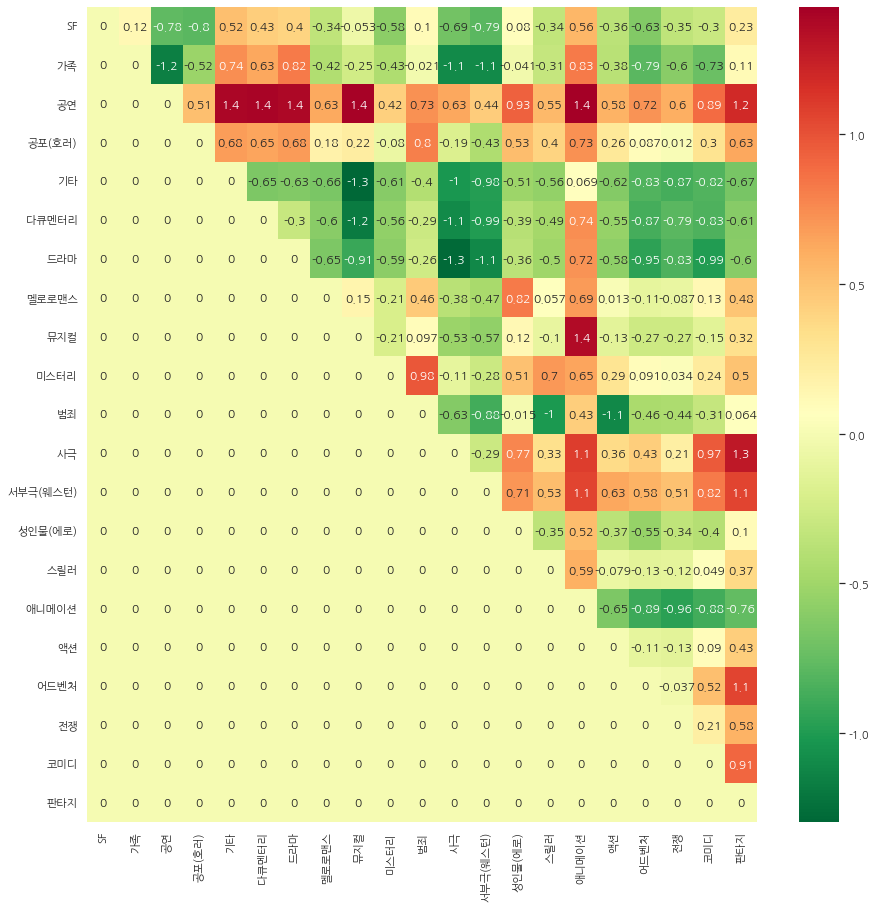

In [99]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(15, 15))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

- 이중에서 Weat Score가 0.8이상 -0.8이하인 값들만 보고 해석을 해보도록 하겠습니다.

In [100]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 0.8 or matrix[i][j] < -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

가족 공연 -1.1595207
가족 드라마 0.8204356
가족 사극 -1.1008453
가족 서부극(웨스턴) -1.0959853
가족 애니메이션 0.8304733
공연 기타 1.3856695
공연 다큐멘터리 1.3960035
공연 드라마 1.3808682
공연 뮤지컬 1.4149843
공연 성인물(에로) 0.93310946
공연 애니메이션 1.4263506
공연 코미디 0.8881816
공연 판타지 1.1914814
기타 뮤지컬 -1.296631
기타 사극 -1.0301154
기타 서부극(웨스턴) -0.98192185
기타 어드벤처 -0.827517
기타 전쟁 -0.8693966
기타 코미디 -0.81911576
다큐멘터리 뮤지컬 -1.18536
다큐멘터리 사극 -1.0981184
다큐멘터리 서부극(웨스턴) -0.9929186
다큐멘터리 어드벤처 -0.8658185
다큐멘터리 코미디 -0.8297222
드라마 뮤지컬 -0.9096925
드라마 사극 -1.2767515
드라마 서부극(웨스턴) -1.1142603
드라마 어드벤처 -0.9509258
드라마 전쟁 -0.8328648
드라마 코미디 -0.99370694
멜로로맨스 성인물(에로) 0.8249083
뮤지컬 애니메이션 1.3614651
미스터리 범죄 0.9789859
범죄 서부극(웨스턴) -0.8792843
범죄 스릴러 -1.0105286
범죄 액션 -1.1096015
사극 애니메이션 1.0891081
사극 코미디 0.9655618
사극 판타지 1.2838049
서부극(웨스턴) 애니메이션 1.0634277
서부극(웨스턴) 코미디 0.82351273
서부극(웨스턴) 판타지 1.0555291
애니메이션 어드벤처 -0.8929417
애니메이션 전쟁 -0.9572705
애니메이션 코미디 -0.88172275
어드벤처 판타지 1.0619186
코미디 판타지 0.91190296


# Okt 정리

#### Target A: 예술 영화 / Target B: 일반 영화

1. 가족 장르 / 공연 장르 || Weat Score : -1.1595207
    - 가족 장르와 공연 장르의 Weat Score가 -1.1595207입니다. 이것은 가족 장르는 예술영화보다는 일반 영화와 연관성이 크고, 공연 장르는 예술 영화에 연관성이 크다고 설명할 수 있습니다.
    
2. 서부극(웨스턴) 장르 / 코미디 장르 || Weat Score : 0.82351273
    - 서부극(웨스턴) 장르와 코미디 장르의 Weat Score가 0.82351273입니다. 이것은 서부극(웨스턴) 장르는 일반 영화보다는 예술 영화와 연관성이 크고, 코미디 장르는 일반 영화와 연관성이 크다고 설명할 수 있습니다.

3. 공연 장르 / 뮤지컬 장르 || Weat Score : 1.4149843
    - 공연 장르와 뮤지컬 장르의 Weat Score가 1.4149843입니다. 이것은 공연 장르는 일반 영화보다는 예술 영화와 연관성이 크고, 뮤지컬 장르는 일반 영화와 연관성이 크다고 설명할 수 있습니다.

# 추가적인 학습
- mecab 형태소 분석기를 통하여 학습을 진행해보고자 하였습니다.

In [105]:
from konlpy.tag import Mecab

def read_token(txt_data):
    mecab = Mecab()
    result = []
    for i in tqdm(txt_data):    
        with open(os.getenv('HOME')+'/aiffel/weat/'+i, 'r') as fread: 
            print(i, '파일을 읽고 있습니다.')
            while True:
                line = fread.readline() 
                if not line: 
                    break 
                tokenlist = mecab.pos(line)
                token = []
                for word in tokenlist:
                    if len(word[0]) > 1 and word[1] in ["NNG"] or len(word[0]) > 1 and word[1] in ["NNP"]:
                        token.append((word[0]))
                result.append(token)
                
    return result

In [106]:
filtered_data = [file for file in txt_files if file not in ['synopsis_gen.txt', 'synopsis_art.txt','synopsis.txt']]

all_mecab_token = read_token(filtered_data)

  0%|          | 0/21 [00:00<?, ?it/s]

synopsis_fantasy.txt 파일을 읽고 있습니다.


  5%|▍         | 1/21 [00:03<01:19,  3.98s/it]

synopsis_crime.txt 파일을 읽고 있습니다.


 10%|▉         | 2/21 [00:04<00:37,  1.98s/it]

synopsis_western.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.


 19%|█▉        | 4/21 [00:06<00:20,  1.19s/it]

synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.


 29%|██▊       | 6/21 [00:07<00:14,  1.00it/s]

synopsis_documentary.txt 파일을 읽고 있습니다.


 33%|███▎      | 7/21 [00:09<00:17,  1.25s/it]

synopsis_comedy.txt 파일을 읽고 있습니다.


 43%|████▎     | 9/21 [00:11<00:11,  1.03it/s]

synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.


 48%|████▊     | 10/21 [00:11<00:09,  1.16it/s]

synopsis_action.txt 파일을 읽고 있습니다.


 57%|█████▋    | 12/21 [00:13<00:06,  1.35it/s]

synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


 62%|██████▏   | 13/21 [00:13<00:05,  1.35it/s]

synopsis_war.txt 파일을 읽고 있습니다.
synopsis_SF.txt 파일을 읽고 있습니다.


 81%|████████  | 17/21 [00:14<00:01,  3.11it/s]

synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.


 90%|█████████ | 19/21 [00:19<00:02,  1.02s/it]

synopsis_show.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.


 95%|█████████▌| 20/21 [00:19<00:00,  1.11it/s]

synopsis_adult.txt 파일을 읽고 있습니다.


100%|██████████| 21/21 [00:20<00:00,  1.03it/s]


In [107]:
mecab_embedding_model = Word2Vec(all_mecab_token, vector_size=100, window=5, min_count=3, sg=1)  

In [108]:
mecab_embedding_model.wv.most_similar(positive=['영화'])

[('작품', 0.7987805008888245),
 ('옴니버스', 0.7793325781822205),
 ('형식', 0.7656552195549011),
 ('신작', 0.7524993419647217),
 ('데뷔작', 0.752444326877594),
 ('전작', 0.751991868019104),
 ('다큐멘터리', 0.7497356534004211),
 ('드라마', 0.7453365325927734),
 ('설정', 0.7388710975646973),
 ('극영화', 0.7351977825164795)]

In [109]:
mecab_embedding_model.wv.most_similar(positive=['취업'])

[('면접', 0.8677621483802795),
 ('수능', 0.8456522226333618),
 ('합격', 0.8438246846199036),
 ('생활비', 0.842150092124939),
 ('취직', 0.8230998516082764),
 ('입시', 0.8173336982727051),
 ('공무원', 0.8144218325614929),
 ('진학', 0.8120610117912292),
 ('시험', 0.8103833198547363),
 ('수험', 0.7968853712081909)]

In [110]:
mecab_embedding_model.wv.most_similar(positive=['코끼리'])

[('조련사', 0.789124608039856),
 ('보리', 0.7729528546333313),
 ('문어', 0.7687909007072449),
 ('양말', 0.7679651379585266),
 ('초원', 0.7666668891906738),
 ('말썽꾸러기', 0.7662115097045898),
 ('동물원', 0.761194109916687),
 ('호랑이', 0.7534505724906921),
 ('토끼', 0.7533736228942871),
 ('늑대', 0.7532776594161987)]

In [111]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def target_token(file_name):
    mecab = Mecab()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = mecab.pos(line)
            for word in tokenlist:
                if len(word[0]) > 1 and word[1] in ["NNG"] or len(word[0]) > 1 and word[1] in ["NNP"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [112]:
art = target_token(art_txt)
gen = target_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [120]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 43352)


In [121]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

n = 20
w1_, w2_ = [], []
for i in range(200):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 30개 추출한다.
target_art, target_gen = [], []
for i in range(150):
    if (w1_[i] not in w2_) and (w1_[i] in mecab_embedding_model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 30개 추출한다.
for i in range(150):
    if (w2_[i] not in w1_) and (w2_[i] in mecab_embedding_model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [122]:
print(target_art)

['모두', '프랑스', '만남', '파리', '공연', '노래', '소식', '연애', '갈등', '영국', '편지', '완벽', '고백', '시골', '고양이']


In [123]:
print(target_gen)

['애니메이션', '연출', '섹스', '부문', '의도', '부산', '경쟁', '인디', '소리', '부천', '다큐', '환경', '독립', '페스티벌', '경험', '애니', '상상', '공간', '지역', '영상']


In [117]:
def read_token_(file_name):
    mecab = Mecab()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = mecab.pos(line)
            for word in tokenlist:
                if len(word[0]) > 1 and word[1] in ["NNG"] or len(word[0]) > 1 and word[1] in ["NNP"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [118]:
all_mecab_genre = []
for file_name in tqdm(genre_txt):
    all_mecab_genre.append(read_token_(file_name))

  0%|          | 0/21 [00:00<?, ?it/s]

synopsis_SF.txt 파일을 읽고 있습니다.


 10%|▉         | 2/21 [00:00<00:03,  5.38it/s]

synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.


 14%|█▍        | 3/21 [00:00<00:02,  6.66it/s]

synopsis_horror.txt 파일을 읽고 있습니다.


 19%|█▉        | 4/21 [00:01<00:06,  2.55it/s]

synopsis_etc.txt 파일을 읽고 있습니다.


 24%|██▍       | 5/21 [00:01<00:07,  2.08it/s]

synopsis_documentary.txt 파일을 읽고 있습니다.


 29%|██▊       | 6/21 [00:03<00:14,  1.01it/s]

synopsis_drama.txt 파일을 읽고 있습니다.


 33%|███▎      | 7/21 [00:08<00:31,  2.26s/it]

synopsis_romance.txt 파일을 읽고 있습니다.


 38%|███▊      | 8/21 [00:10<00:25,  1.96s/it]

synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.


 48%|████▊     | 10/21 [00:10<00:11,  1.09s/it]

synopsis_crime.txt 파일을 읽고 있습니다.


 52%|█████▏    | 11/21 [00:10<00:09,  1.11it/s]

synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.


 67%|██████▋   | 14/21 [00:11<00:03,  1.82it/s]

synopsis_thriller.txt 파일을 읽고 있습니다.


 71%|███████▏  | 15/21 [00:11<00:03,  1.81it/s]

synopsis_animation.txt 파일을 읽고 있습니다.


 76%|███████▌  | 16/21 [00:13<00:03,  1.31it/s]

synopsis_action.txt 파일을 읽고 있습니다.


 86%|████████▌ | 18/21 [00:15<00:02,  1.37it/s]

synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.


 90%|█████████ | 19/21 [00:15<00:01,  1.77it/s]

synopsis_comedy.txt 파일을 읽고 있습니다.


100%|██████████| 21/21 [00:16<00:00,  1.26it/s]

synopsis_fantasy.txt 파일을 읽고 있습니다.


In [124]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_mecab_genre)

print(X.shape)

(21, 44641)


In [125]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 20):
        if vectorizer.get_feature_names()[w[i][j][0]] in mecab_embedding_model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 자신, 지구, 시작, 사람, 인류, 인간, 세계, 우주, 미래, 로봇, 박사, 친구, 거대, 외계, 우주선, 생명체, 존재, 세상, 발견, 시간, 
가족: 엄마, 아빠, 영화제, 가족, 자신, 친구, 아버지, 시작, 아들, 사랑, 마을, 국제, 아이, 낙타, 할머니, 사람, 씨제이, 학교, 동구, 세상, 
공연: 사랑, 오페라, 비올레타, 실황, 스카르피, 토스카, 백작, 자신, 카바, 레오노라, 공연, 알프레도, 오텔로, 리골레토, 베르디, 왕자, 콘서트, 만리, 타미, 비바, 
공포(호러): 친구, 시작, 사람, 자신, 공포, 사건, 발견, 죽음, 남자, 이상, 마을, 영화, 여자, 가족, 악령, 아이, 소녀, 사실, 비밀, 병원, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 남자, 여자, 친구, 사랑, 시작, 페스티벌, 미디어, 엄마, 작품, 독립, 연출, 아이, 
다큐멘터리: 영화제, 영화, 다큐, 다큐멘터리, 국제, 사람, 이야기, 감독, 자신, 서울, 세계, 여성, 시작, 가족, 한국, 환경, 작품, 아이, 사회, 모습, 
드라마: 자신, 영화제, 사랑, 영화, 사람, 시작, 남자, 친구, 국제, 여자, 이야기, 엄마, 단편, 가족, 아버지, 서울, 아이, 마음, 아들, 남편, 
멜로로맨스: 사랑, 남자, 자신, 친구, 여자, 시작, 남편, 사람, 섹스, 마음, 결혼, 아내, 관계, 부부, 영화, 엄마, 서로, 아버지, 시간, 사이, 
뮤지컬: 뮤지컬, 사랑, 지모도, 에스메랄다, 영화, 프롤, 스카르피, 음악, 충무로, 모차르트, 카바, 자신, 영화제, 토스카, 시작, 시앙치, 데이비, 팬텀, 최고, 바흐, 
미스터리: 사건, 시작, 자신, 사람, 친구, 사고, 발견, 진실, 죽음, 기억, 남자, 아내, 살인, 민혁, 아이, 여자, 영화, 형사, 비밀, 사실, 
범죄: 사건, 자신, 경찰, 시작, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 수사, 여자, 발견, 범인, 은행, 친구, 계획, 작전, 영화, 
사극

In [126]:
matrix_ = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [127]:
X = np.array([mecab_embedding_model.wv[word] for word in target_art])
Y = np.array([mecab_embedding_model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([mecab_embedding_model.wv[word] for word in attributes[i]])
        B = np.array([mecab_embedding_model.wv[word] for word in attributes[j]])
        matrix_[i][j] = weat_score(X, Y, A, B)

In [128]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix_[i][j])

SF 가족 -0.14636818
SF 공연 -1.0929637
SF 공포(호러) -0.92606366
SF 기타 0.6379907
SF 다큐멘터리 0.64751464
SF 드라마 0.20599487
SF 멜로로맨스 -0.5606704
SF 뮤지컬 -0.13884908
SF 미스터리 -0.78754777
SF 범죄 -0.41834643
SF 사극 -0.80523354
SF 서부극(웨스턴) -0.85318285
SF 성인물(에로) -0.17986763
SF 스릴러 -0.7935381
SF 애니메이션 0.6573435
SF 액션 -0.64281857
SF 어드벤처 -0.64720803
SF 전쟁 -0.06534255
SF 코미디 -0.49925715
SF 판타지 -0.00030300408
가족 공연 -1.3483903
가족 공포(호러) -0.78805053
가족 기타 1.1534992
가족 다큐멘터리 1.1210775
가족 드라마 0.86857086
가족 멜로로맨스 -0.5477915
가족 뮤지컬 -0.04178248
가족 미스터리 -0.65528435
가족 범죄 -0.27638984
가족 사극 -0.9740108
가족 서부극(웨스턴) -1.040529
가족 성인물(에로) -0.07919305
가족 스릴러 -0.70543194
가족 애니메이션 1.2104491
가족 액션 -0.38976318
가족 어드벤처 -0.39706132
가족 전쟁 0.04643878
가족 코미디 -0.7733664
가족 판타지 0.33891073
공연 공포(호러) 0.7961131
공연 기타 1.7204235
공연 다큐멘터리 1.769568
공연 드라마 1.6204121
공연 멜로로맨스 0.74756277
공연 뮤지컬 1.7190742
공연 미스터리 0.78164494
공연 범죄 1.1627505
공연 사극 1.1327196
공연 서부극(웨스턴) 0.81538725
공연 성인물(에로) 0.97935224
공연 스릴러 0.7503394
공연 애니메이션 1.7807666
공연 액션 1.07120

<AxesSubplot:>

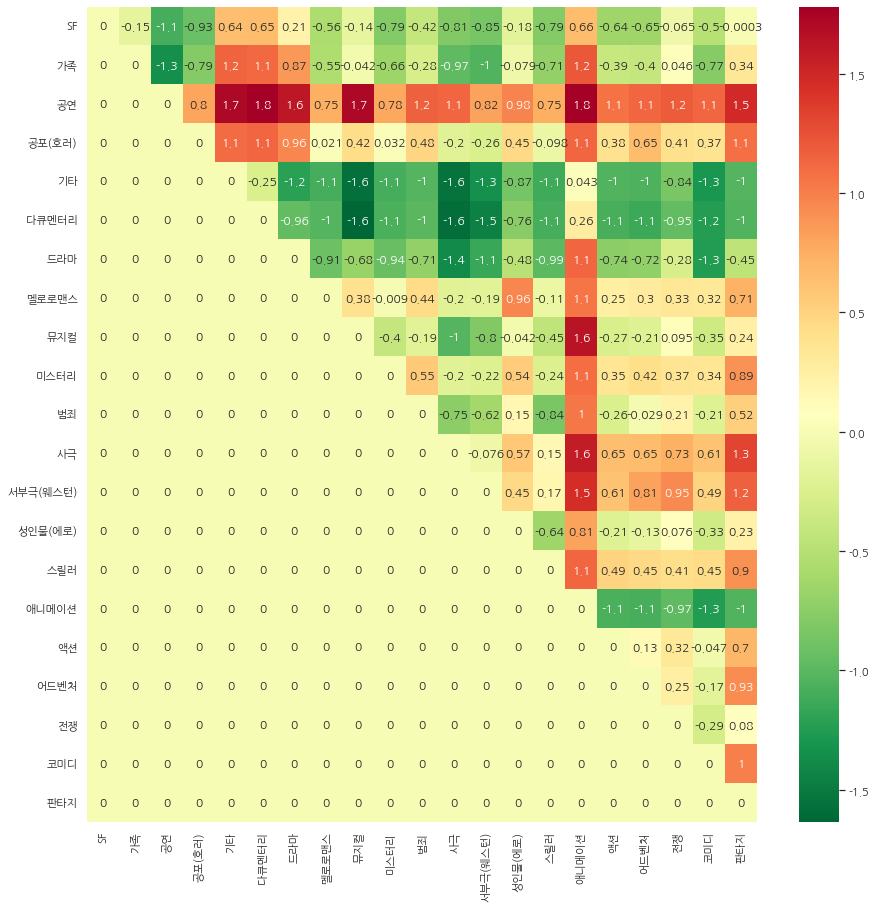

In [129]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(15, 15))

ax = sns.heatmap(matrix_, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

In [130]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix_[i][j] > 0.8 or matrix_[i][j] < -0.8:
            print(genre_name[i], genre_name[j],matrix_[i][j])

SF 공연 -1.0929637
SF 공포(호러) -0.92606366
SF 사극 -0.80523354
SF 서부극(웨스턴) -0.85318285
가족 공연 -1.3483903
가족 기타 1.1534992
가족 다큐멘터리 1.1210775
가족 드라마 0.86857086
가족 사극 -0.9740108
가족 서부극(웨스턴) -1.040529
가족 애니메이션 1.2104491
공연 기타 1.7204235
공연 다큐멘터리 1.769568
공연 드라마 1.6204121
공연 뮤지컬 1.7190742
공연 범죄 1.1627505
공연 사극 1.1327196
공연 서부극(웨스턴) 0.81538725
공연 성인물(에로) 0.97935224
공연 애니메이션 1.7807666
공연 액션 1.0712061
공연 어드벤처 1.1375837
공연 전쟁 1.1925166
공연 코미디 1.1341758
공연 판타지 1.4861716
공포(호러) 기타 1.1083522
공포(호러) 다큐멘터리 1.1315817
공포(호러) 드라마 0.9610744
공포(호러) 애니메이션 1.1327871
공포(호러) 판타지 1.079775
기타 드라마 -1.2169082
기타 멜로로맨스 -1.0933121
기타 뮤지컬 -1.5812117
기타 미스터리 -1.0881685
기타 범죄 -1.0304931
기타 사극 -1.5511569
기타 서부극(웨스턴) -1.3397267
기타 성인물(에로) -0.8677957
기타 스릴러 -1.1207787
기타 액션 -1.0439297
기타 어드벤처 -1.049191
기타 전쟁 -0.8413162
기타 코미디 -1.2908198
기타 판타지 -1.0279772
다큐멘터리 드라마 -0.95843184
다큐멘터리 멜로로맨스 -1.0319407
다큐멘터리 뮤지컬 -1.6350276
다큐멘터리 미스터리 -1.0744107
다큐멘터리 범죄 -1.0060928
다큐멘터리 사극 -1.5876889
다큐멘터리 서부극(웨스턴) -1.4585811
다큐멘터리 스릴러 -1.0988027
다

# Okt와 Mecab 사전 편향성 비교

# 전체 회고

# 참고 자료